In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from evaluate.helper_functions import *

# restrict tensorflow to only one GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
def load_mnist_data():
    """
    Download mnist data if it does not already exist in directory mnist_data, else load it from directory.
    """
    try:
        x_train = np.load('mnist_data/train_data.npy')
        y_train = np.load('mnist_data/train_labels.npy')
        x_test = np.load('mnist_data/test_data.npy')
        y_test = np.load('mnist_data/test_labels.npy')

        print('mnist/data already exists, loaded files.')

    except IOError:
        if not os.path.exists('mnist_data'):
            os.makedirs('mnist_data')
        print('Downloading mnist data.')
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

        print('saving mnist data in mnist_data/')
        np.save('mnist_data/train_data', x_train)
        np.save('mnist_data/train_labels', y_train)
        np.save('mnist_data/test_data', x_test)
        np.save('mnist_data/test_labels', y_test)

    # Reshape data into shape [num_samples,num_features]
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    print('shape training examples: ', x_train.shape)
    print('shape training labels: ', y_train.shape)
    print('shape test examples: ', x_test.shape)
    print('shape test labels: ', y_test.shape)

    return (x_train, y_train), (x_test, y_test)


def threshold_data(data, threshold):
    """
    threshold data with threshold value
    :param data: numpy array
    :param threshold: float
    :return: thresholded data
    """
    data = np.where(data >= threshold, np.ones_like(data), np.zeros_like(data))
    data = data.astype(np.float32)
    return data

In [3]:
# load data
(x_train, y_train), (x_test, y_test) = load_mnist_data()

mnist/data already exists, loaded files.
shape training examples:  (60000, 784)
shape training labels:  (60000,)
shape test examples:  (10000, 784)
shape test labels:  (10000,)


In [4]:
# normalize data
x_train = (x_train/255).astype(np.float32)
x_test = (x_test/255).astype(np.float32)

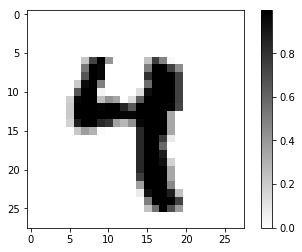

In [5]:
# plot one random image to check if the format is correct
plt.imshow(x_train[np.random.randint(x_train.shape[0]), :].reshape([28, 28]), cmap='binary')
plt.colorbar()
plt.show()

In [ ]:
# Set up Deep Belief Network
layer_sizes = [784, 256, 256]
layer_types = ['gr', 'gr', 'gr', 'gr', 'gr', 'gr']
mnist_dbn = generate_dbn(layer_sizes, layer_types)

In [ ]:
# training parameters
dbn_train_params = {
    'epochs': [42, 42, 42, 42, 42, 42],  # number of training epochs
    'batch_size': [128, 128, 128, 128, 128, 128],  # size of one training batch
    'cd_steps': [1, 1, 1, 1, 1, 1],  # number of CD training steps
    'update_vbiases': [True, True, True, True, True, True],  # if false vbiases are set to zero throughout the training
    'learning_rate': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01],  # learning rate at the begin of training
    'lr_decay': [(5, 0.5), (5, 0.5), (5, 0.5), (5, 0.5), (5, 0.5), (5, 0.5)],  # decay of learning rate (every epochs,decay factor)
    'summary_frequency': [250, 250, 250, 250, 250, 250],  # write to summary every x batches
    'sparsity_rate': [0.05, 0.01, 0.01, 0.01, 0.05, 0.05],  # rate with which sparsity is enforced
    'sparsity_goal': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # goal activation probability
}

In [ ]:
# Train DBN
summaries_path = 'gr_mnist_test1/'

for li in range(len(mnist_dbn)):
    # set up layer summary path
    summary_path = summaries_path + 'layer{}'.format(li)

    # get training parameters for each layer from DBN_train_params
    layer = mnist_dbn[li]
    epochs = extract_value(dbn_train_params, 'epochs', li, 10)
    batch_size = extract_value(dbn_train_params, 'batch_size', li, 32)
    cd_steps = extract_value(dbn_train_params, 'cd_steps', li, 1)
    update_vbiases = extract_value(dbn_train_params, 'update_vbiases', li, False)
    start_learning_rate = extract_value(dbn_train_params, 'learning_rate', li, 0.1)
    lr_decay = extract_value(dbn_train_params, 'lr_decay', li, (10, 0.9))
    summary_frequency = extract_value(dbn_train_params, 'summary_frequency', li, 10)
    sparsity_rate = extract_value(dbn_train_params, 'sparsity_rate', li, 0)
    sparsity_goal = extract_value(dbn_train_params, 'sparsity_goal', li, 0)

    layer.train_rbm(train_data=x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    summary_path=summary_path,
                    summary_frequency=summary_frequency,
                    dbn=mnist_dbn,
                    update_vbiases=update_vbiases,
                    start_learning_rate=start_learning_rate,
                    learning_rate_decay=lr_decay,
                    cd_steps=cd_steps,
                    sparsity_rate=sparsity_rate,
                    sparsity_goal=sparsity_goal)

    # save trained dbn:
    pickle_out = open(summaries_path + 'dbn.pickle', 'wb')
    pickle.dump(mnist_dbn, pickle_out)
    pickle_out.close()

    # save parameter dicts:
    pickle_out = open(summaries_path + 'dbn_train_params.pickle', 'wb')
    pickle.dump(dbn_train_params, pickle_out)
    pickle_out.close()

In [6]:
# load DBN
dbn_path = 'gr_mnist_test1/'
dbn_path = os.fspath(os.path.join(dbn_path, 'dbn.pickle'))
dbn = load_dbn(dbn_path)

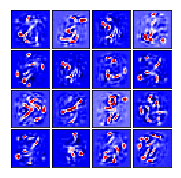

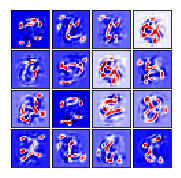

In [7]:
# plot features
save_path = 'gr_mnist_test1/features/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
for layer_index in range(len(dbn)):
    layer = dbn[layer_index]
    inds = np.random.choice(range(layer.num_hunits), size=16, replace=False)

    # plot features with downward propagation
    receptive_fields = downward_propagate_features(dbn, layer_index, inds,
                                                   num_runs=1,
                                                   num_neurons=10,
                                                   activation_value=100.0)
    fig, axes = plt.subplots(4, 4, figsize=(2.895, 2.895))
    for c, ax in enumerate(axes.flat):
        receptive_field = receptive_fields[c]
        ax.imshow(receptive_field.reshape([28, 28]), cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if save_path is not None:
        plt.savefig(save_path + 'receptive_fields_layer{}.png'.format(layer_index), format='png')
    plt.show()

In [ ]:
import evaluate.dimensionless_disrcrimination_value as ddv
from evaluate.plot import *

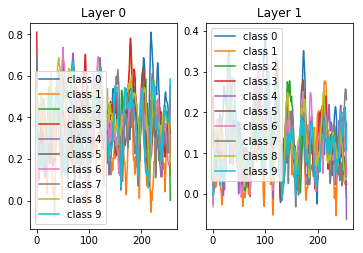

In [8]:
save_path = 'gr_mnist_test1/'
plot_class_activations(save_path, dbn, x_test, y_test, 1, one_hot=False)

In [ ]:
# plot pca and tsne and calculate discrimination value
save_path = 'gr_mnist_test1/pca_and_tsne/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# make samples indices
np.random.seed(420)
test_indices = make_sample_indices(x_test, 400)

test_samples = x_test[test_indices]
test_labels = y_test[test_indices]

# make pca and tsne of the input layer
pca_samples = calculate_pca(test_samples)
tsne_samples = calculate_tsne(test_samples)

# save plots of pca and tsne of the input layer
pca_plot = plot_pca_or_tsne(pca_samples, test_labels, one_hot_labels=False)
plt.savefig(save_path + 'pca_input_layer.png', format='png')
plt.show()

tsne_plot = plot_pca_or_tsne(tsne_samples, test_labels, one_hot_labels=False)
plt.savefig(save_path + 'tsne_input_layer.png', format='png')
plt.show()

# calculate discrimination value
discrimination_values = []
discrimination_value = ddv.discrimination_value(test_samples,
                                                test_labels,
                                                norm='z')
discrimination_values.append(discrimination_value)

# calculate layerwies activations
layer_activations = layerwise_activations(dbn, test_samples, num_activations=1)

# make and plot pca and tsne for higher layers, calculate discrimination value
for layer_index in range(len(dbn)):
    pca_samples = calculate_pca(layer_activations[layer_index])
    tsne_samples = calculate_tsne(layer_activations[layer_index])

    pca_plot = plot_pca_or_tsne(pca_samples, test_labels, one_hot_labels=False)
    plt.savefig(save_path + 'pca_layer{}.png'.format(layer_index), format='png')
    plt.show()

    tsne_plot = plot_pca_or_tsne(tsne_samples, test_labels, one_hot_labels=False)
    plt.savefig(save_path + 'tsne_layer{}.png'.format(layer_index), format='png')
    plt.show()

    discrimination_value = ddv.discrimination_value(layer_activations[layer_index],
                                                    test_labels,
                                                    norm='z')
    discrimination_values.append(discrimination_value)

plt.plot(discrimination_values)
plt.savefig(save_path + 'discrimination_values.png', format='png')
plt.show()

In [ ]:
# compare pre-trained vs not pre-trained

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from evaluate.helper_functions import load_dbn
from evaluate.finetune_dbn import keras_model_from_dbn
from evaluate.feedforward import *
from tensorflow.keras import backend as K

In [ ]:
save_path = os.path.join('gr_mnist_test1', 'finetune/')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# load dbn
dbn_path = 'gr_mnist_test1/'
dbn = load_dbn(dbn_path + 'dbn.pickle')

# scale weights of dbn
for c, layer in enumerate(dbn):
    scale_factor = 0.04/(c+1)/np.mean(np.abs(layer.weights))
    layer.weights = scale_factor*layer.weights
    print(np.mean(np.abs(layer.weights)))

# load data
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# normalize data
x_train = (x_train/255).astype(np.float32)
x_test = (x_test/255).astype(np.float32)

# make one hot labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# set up model
num_classes = 10
dropout_rates = [0.0, 0.0, 0.0]
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = keras_model_from_dbn(dbn, num_classes, dropout_rates, optimizer, use_hbiases=True)
model.summary()

# train model:
batch_size = 128
epochs = 50
history = model.fit(x=x_train[:3000],
                    y=y_train[:3000],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=2)

pickle_out = open(save_path + 'finetune_history.pickle', 'wb')
pickle.dump(history.history, pickle_out)
pickle_out.close()

plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Test Acc')
plt.savefig(save_path + 'finettune_acc.png', format='png')
plt.close()
K.clear_session()

# compare with feedforward
finetune_test_acc = history.history['val_acc']

# set up model
num_classes = 10
layer_sizes = [dbn[0].num_vunits]
layer_sizes = layer_sizes + [layer.num_hunits for layer in dbn]
dropout_rates = [0.0, 0.0, 0.0]
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = feedforward_network(layer_sizes=layer_sizes,
                            dropout_rates=dropout_rates,
                            num_classes=num_classes,
                            optimizer=optimizer,
                            activation='sigmoid')
model.summary()

# train model:
batch_size = 128
epochs = 50
history = model.fit(x=x_train[:3000],
                    y=y_train[:3000],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=2)

pickle_out = open(save_path + 'feedforward_history.pickle', 'wb')
pickle.dump(history.history, pickle_out)
pickle_out.close()

plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Test Acc')
plt.savefig(save_path + 'feedforward_acc.png', format='png')
plt.close()

feedforward_test_acc = history.history['val_acc']

plt.plot(finetune_test_acc)
plt.plot(feedforward_test_acc)
plt.show()